In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!pip install -r ../requirements.txt

In [3]:
import os

target_dir = "../"
zip_file_path = "generated.zip"

if not os.path.exists(target_dir + 'generated'):
    print(f"The directory {target_dir} does not exist. Proceeding with download.")

    !apt-get update
    !apt-get install unzip
    
    !curl "https://drive.usercontent.google.com/download?id=10xaugPOoC3SraTwp90sfqSMYQEQK96Ls&confirm=xxx" -o {zip_file_path}
    !mkdir -p {target_dir}
    
    !unzip {zip_file_path} -d {target_dir}
    
    print(f"File downloaded and extracted to {target_dir}")
    
    !rm {zip_file_path}
else:
    print(f"The directory {target_dir} already exists. No action taken.")

The directory ../ already exists. No action taken.


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
import sys
from tqdm import tqdm
from datetime import datetime
pd.options.mode.chained_assignment = None
pd.options.display.float_format = '{:.2f}'.format

from pathlib import Path

repo_root = Path.cwd().parent.resolve()
sys.path.append(str(repo_root))

from sklearn.model_selection import train_test_split
from src.data.auction_dataset import AuctionDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
filters = [
    ("g_hours_on_sale_max", "<=", 50),
    ("g_current_hours_max", "<=", 50),
    ("g_hours_on_sale_len", "<=", 64),
    ("record", ">=", "2025-04-15"),
]

pairs = pd.read_parquet("../generated/auction_indices.parquet", engine="pyarrow", filters=filters)

pairs.head()

,record,item_index,g_hours_on_sale_len,g_hours_on_sale_mean,g_hours_on_sale_std,g_hours_on_sale_min,g_hours_on_sale_max,g_current_hours_mean,g_current_hours_std,g_current_hours_min,g_current_hours_max
0,2025-04-15 00:00:00,15074,24,8.00,8.55,0.00,30.00,20.96,15.95,1.00,48.00
1,2025-04-15 00:00:00,17351,8,22.75,14.59,0.00,46.00,21.38,16.39,1.00,48.00
2,2025-04-15 00:00:00,11928,1,0.00,0.00,0.00,0.00,48.00,0.00,48.00,48.00
3,2025-04-15 00:00:00,16090,4,3.25,3.70,0.00,9.00,33.50,19.16,1.00,48.00
4,2025-04-15 00:00:00,15077,24,10.75,9.22,0.00,30.00,30.54,11.35,9.00,48.00


## Prepare and balance data

In [6]:
print(f"Pairs: {len(pairs)}")

split_idx = int(len(pairs) * 0.95)

train_pairs = pairs.iloc[:split_idx]
train_pairs = train_pairs.iloc[: int(len(train_pairs) * 0.90)]

print(f"Train pairs: {len(train_pairs)}")

val_pairs = pairs.iloc[split_idx:]

print(f"Val pairs: {len(val_pairs)}")

del pairs

Pairs: 47538473
Train pairs: 40645394
Val pairs: 2376924


In [7]:
train_pairs.tail()

,record,item_index,g_hours_on_sale_len,g_hours_on_sale_mean,g_hours_on_sale_std,g_hours_on_sale_min,g_hours_on_sale_max,g_current_hours_mean,g_current_hours_std,g_current_hours_min,g_current_hours_max
40645389,2025-08-02 00:00:00,17039,13,12.08,12.33,0.00,45.00,6.54,4.20,2.00,19.00
40645390,2025-08-02 00:00:00,17302,10,11.00,13.70,0.00,45.00,6.80,5.62,1.00,19.00
40645391,2025-08-02 00:00:00,13944,4,22.50,16.13,1.00,45.00,9.50,6.18,2.00,19.00
40645392,2025-08-02 00:00:00,180,3,25.00,4.24,19.00,28.00,14.00,7.07,4.00,19.00
40645393,2025-08-02 00:00:00,15673,1,28.00,0.00,28.00,28.00,19.00,0.00,19.00,19.00


In [8]:
val_pairs.head()

,record,item_index,g_hours_on_sale_len,g_hours_on_sale_mean,g_hours_on_sale_std,g_hours_on_sale_min,g_hours_on_sale_max,g_current_hours_mean,g_current_hours_std,g_current_hours_min,g_current_hours_max
45161549,2025-08-13 19:00:00,1948,5,9.20,10.15,2.00,29.00,23.40,9.56,15.00,42.00
45161550,2025-08-13 19:00:00,16542,6,15.50,10.78,2.00,31.00,26.50,10.01,16.00,42.00
45161551,2025-08-13 19:00:00,5804,11,16.55,14.81,1.00,44.00,15.00,15.42,3.00,45.00
45161552,2025-08-13 19:00:00,12805,1,15.00,0.00,15.00,15.00,32.00,0.00,32.00,32.00
45161553,2025-08-13 19:00:00,1713,2,17.00,6.00,11.00,23.00,17.50,17.50,0.00,35.00


(array([ 510231.,  690184.,  680878., 1306687., 1661578., 1670202.,
        2550607., 2859055., 2684577., 3398069., 3410066., 2786809.,
        3092891., 2730912., 1930935., 1926664., 1528675., 1011706.,
        1010524.,  769187.,  463974.,  485663.,  375992.,  213783.,
         275139.,  227389.,  118109.,  180954.,   87152.,    6802.]),
 array([ 0.        ,  1.66666667,  3.33333333,  5.        ,  6.66666667,
         8.33333333, 10.        , 11.66666667, 13.33333333, 15.        ,
        16.66666667, 18.33333333, 20.        , 21.66666667, 23.33333333,
        25.        , 26.66666667, 28.33333333, 30.        , 31.66666667,
        33.33333333, 35.        , 36.66666667, 38.33333333, 40.        ,
        41.66666667, 43.33333333, 45.        , 46.66666667, 48.33333333,
        50.        ]),
 <BarContainer object of 30 artists>)

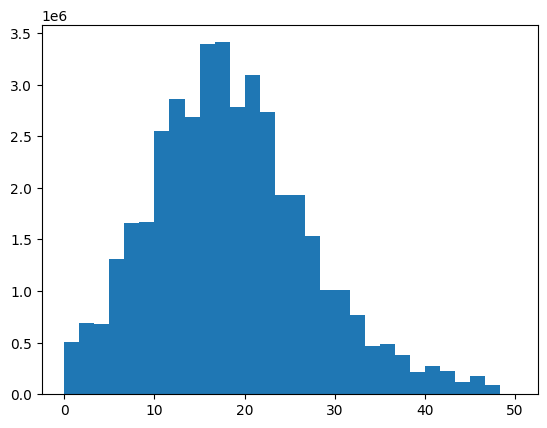

In [9]:
# histogram of group_hours_on_sale_mean
plt.hist(train_pairs['g_hours_on_sale_mean'], bins=30)

In [10]:
val_pairs.sample(5)

,record,item_index,g_hours_on_sale_len,g_hours_on_sale_mean,g_hours_on_sale_std,g_hours_on_sale_min,g_hours_on_sale_max,g_current_hours_mean,g_current_hours_std,g_current_hours_min,g_current_hours_max
45961520,2025-08-15 21:00:00,1248,6,12.83,9.70,0.00,24.00,16.50,16.48,1.00,48.00
45180412,2025-08-13 20:00:00,6623,7,21.57,13.64,3.00,43.00,16.86,15.92,0.00,44.00
45488593,2025-08-14 15:00:00,1442,5,8.20,4.66,2.00,15.00,12.40,3.88,8.00,19.00
46193847,2025-08-16 12:00:00,13748,2,10.00,5.00,5.00,15.00,37.00,5.00,32.00,42.00
47212557,2025-08-19 03:00:00,13352,7,12.86,8.87,2.00,21.00,10.14,9.61,2.00,28.00


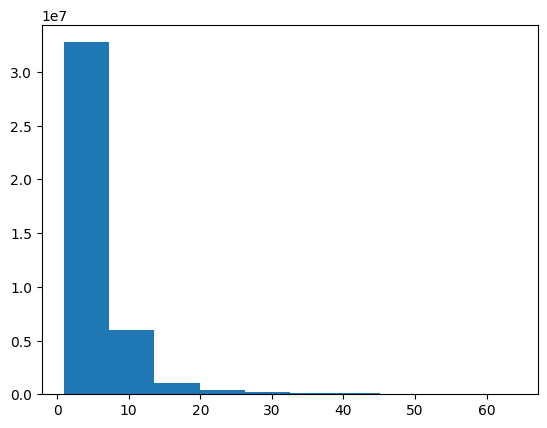

In [11]:
plt.hist(train_pairs['g_hours_on_sale_len'], bins=10)
plt.show()

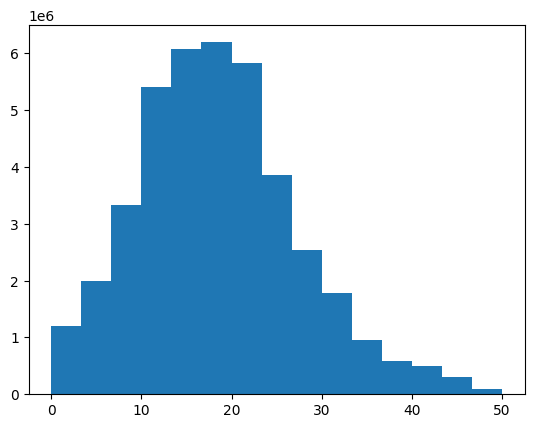

In [12]:
plt.hist(train_pairs['g_hours_on_sale_mean'], bins=15)
plt.show()

In [13]:
import json
import os

mappings_dir = '../generated/mappings'

with open(os.path.join(mappings_dir, 'item_to_idx.json'), 'r') as f:
    item_to_idx = json.load(f)

with open(os.path.join(mappings_dir, 'context_to_idx.json'), 'r') as f:
    context_to_idx = json.load(f)
    
with open(os.path.join(mappings_dir, 'bonus_to_idx.json'), 'r') as f:
    bonus_to_idx = json.load(f)

with open(os.path.join(mappings_dir, 'modtype_to_idx.json'), 'r') as f:
    modtype_to_idx = json.load(f)

In [14]:
feature_stats = torch.load('../generated/feature_stats.pt')

In [15]:
from src.data.auction_dataset import AuctionDataset
from src.data.utils import collate_auctions

batch_size = 128

train_dataset = AuctionDataset(train_pairs, feature_stats=feature_stats, path='../generated/sequences.h5')
val_dataset = AuctionDataset(val_pairs, feature_stats=feature_stats, path='../generated/sequences.h5')

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_auctions, num_workers=4, prefetch_factor=8, pin_memory=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_auctions, num_workers=4, prefetch_factor=8, pin_memory=True)

## Model definition

In [16]:
test_data_loader = True

if test_data_loader:
    iter_loader = iter(train_dataloader)
    batch = next(iter_loader)
    auctions = batch['auctions']
    item_index = batch['item_index']
    contexts = batch['contexts']
    bonus_lists = batch['bonus_lists']
    modifier_types = batch['modifier_types']
    modifier_values = batch['modifier_values']
    current_hours_raw = batch['current_hours_raw']
    time_left_raw = batch['time_left_raw']
    y = batch['target']

    print(f'auctions: {auctions.shape}')
    print(f'item_index: {item_index.shape}')
    print(f'contexts: {contexts.shape}')
    print(f'bonus_lists: {bonus_lists.shape}')
    print(f'modifier_types: {modifier_types.shape}')
    print(f'modifier_values: {modifier_values.shape}')
    
    print(f'y: {y.shape}')

auctions: torch.Size([128, 37, 9])
item_index: torch.Size([128, 37])
contexts: torch.Size([128, 37])
bonus_lists: torch.Size([128, 37, 7])
modifier_types: torch.Size([128, 37, 9])
modifier_values: torch.Size([128, 37, 9])
y: torch.Size([128, 37])


In [17]:
from src.models.auction_transformer import AuctionTransformer

input_size = 9
embedding_dim = 32
d_model = 256
dim_feedforward = d_model * 4
nhead = 16
num_layers = 4
dropout_p = 0.0
n_items = len(item_to_idx)
n_contexts = len(context_to_idx) + 1
n_bonuses = len(bonus_to_idx)
n_modtypes = len(modtype_to_idx)

model = AuctionTransformer(
    input_size, 
    n_items, 
    n_contexts,
    n_bonuses,
    n_modtypes,
    embedding_dim, 
    d_model, 
    dim_feedforward, 
    nhead, 
    num_layers,
    dropout_p=dropout_p,
    learning_rate=1e-4,
    logging_interval=1000,
    quantiles=[0.1, 0.5, 0.9],
    log_raw_batch_data=True,
    log_step_predictions=True,
)

print(sum(p.numel() for p in model.parameters()))

4094499


## Training

In [ ]:
import lightning as L
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.callbacks import ModelCheckpoint

!rm -rf ../generated/logs

name = 'auction-transformer-4M-quantile'

logger = WandbLogger(
    project="auction_transformer",
    name=name
)

checkpoint_callback = ModelCheckpoint(
    dirpath=f'../models/{name}',
    filename='epoch_{epoch:02d}',
    save_top_k=-1,
    every_n_epochs=1,
    save_last=True
)

trainer = L.Trainer(
    max_epochs=1,
    accelerator='gpu',
    devices=1,
    log_every_n_steps=10,
    logger=logger,
    limit_val_batches=500,
    val_check_interval=0.1,
    precision="bf16",
    callbacks=[checkpoint_callback],
    gradient_clip_val=3.0,
)

trainer.fit(model, train_dataloader, val_dataloader)

/home/angel/miniconda3/lib/python3.11/site-packages/lightning/fabric/connector.py:571: `precision=bf16` is supported for historical reasons but its usage is discouraged. Please set your precision to bf16-mixed instead!
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
wandb: Currently logged in as: angel-zenteno-u (angel-urq-epfl) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.
/home/angel/miniconda3/lib/python3.11/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:231: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

   | Name                      | Type               | Params | Mode 
--------------------------------------------------------------------------
0  | input_projection          | Linear             | 10.8 K | train
1  | output_projection         | Sequential         | 266 K  | train
2  | item_embeddings           | Embedding          | 567 K  | train
3  | context_embeddings        | Embedding          | 2.0 K  | train
4  | bonus_embeddings          | Embedding          | 45.9 K | train
5  | modifier_embeddings       | Embedding          | 672    | train
6  | positional_embeddings     | Embedding          | 16.4 K | train
7  | context_c

total steps: 317543


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/angel/miniconda3/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:484: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Logging quantile metrics at step 0
Logging raw batch data
Logging quantile metrics at step 0
Logging raw batch data


Training: |          | 0/? [00:00<?, ?it/s]

Logging metrics at step 0
Logging quantile metrics at step 0
